In [1]:
#pick one that is about Neptune size and short period
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk
import batman

In [2]:
search_result = lk.search_targetpixelfile('TIC 267263253', mission='TESS', sector=1)

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


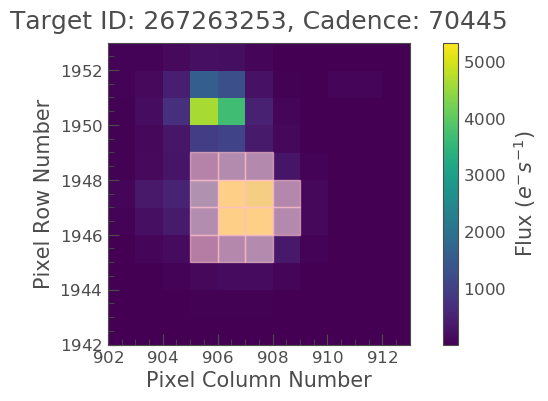

In [3]:
tpf = search_result.download(quality_bitmask='default')
#viewing the aperture
tpf.plot(aperture_mask=tpf.pipeline_mask);

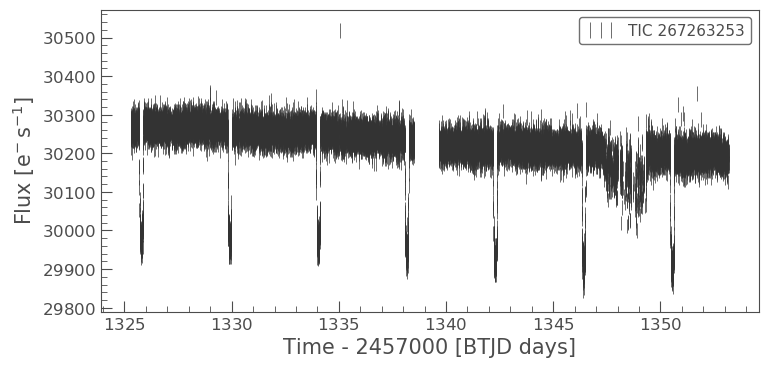

In [4]:
lc = tpf.to_lightcurve()
lc.errorbar();

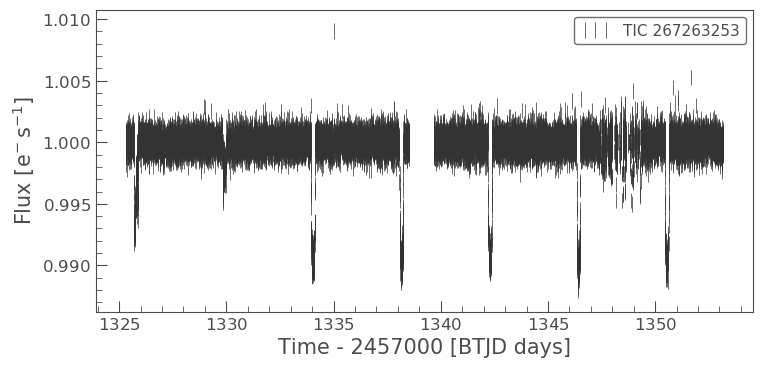

In [5]:
#cleaning up the light curve
flat_lc = lc.flatten(window_length=1001) #lower window_length smooths more
flat_lc.errorbar();

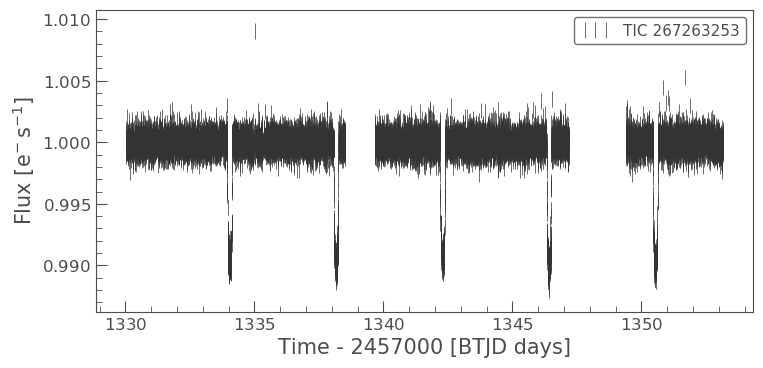

In [6]:
mask = (flat_lc.time < 1347.2) | (flat_lc.time > 1349.4) #keeps all data in specified times
mask_lc = flat_lc[mask]
mask2 = (mask_lc.time < 1325) | (mask_lc.time > 1330)
masked_lc = mask_lc[mask2]
masked_lc.errorbar()

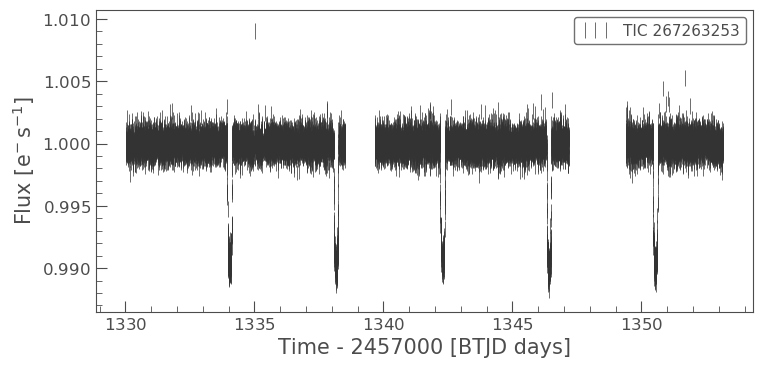

In [7]:
clipped_lc = masked_lc.remove_outliers(sigma=6) #lower the sigma, the more data gets chopped off
#obviously there's such thing as too low a sigma for seeing planets
clipped_lc.errorbar();

(-0.2, 0.2)

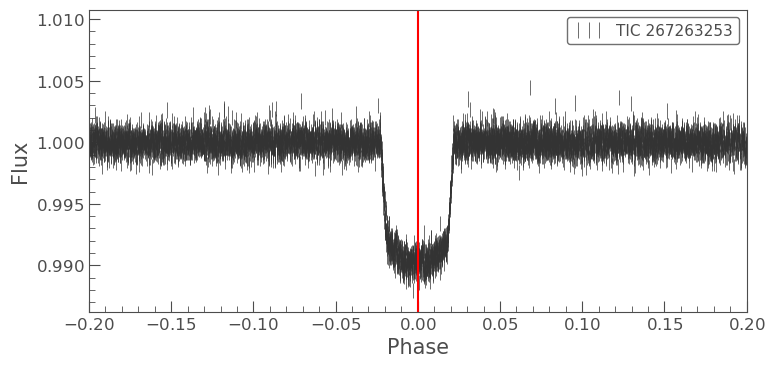

In [8]:
#folding cleaned light curve to see planet transit
folded_lc = masked_lc.fold(period=4.12688,t0=1334.04) #period=planet period, t0=time of first orbit to fold around
folded_lc.errorbar();
plt.axvline(x=0.0,color='r')
plt.xlim(-.2,.2)
#I WANT TO SAY, PHASE IS TIME OVER PERIOD, SO ACCOUNT FOR IT

In [9]:
#now with the light curve properly made and folded, introduce initial fitting

params = batman.TransitParams()
params.t0 = 0.                       #time of inferior conjunction
params.per = 1.                      #orbital period
params.rp = 0.1                      #planet radius (in units of stellar radii)
params.a = 15.                       #semi-major axis (in units of stellar radii)
params.inc = 87.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [.1, 0.3]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

t = np.linspace(-0.05, 0.05, 100)

m = batman.TransitModel(params, folded_lc.time)    #initializes model
flux = m.light_curve(params)          #calculates light curve

(-0.15, 0.15)

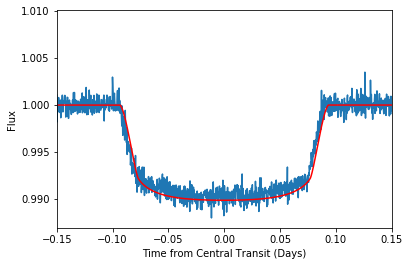

In [55]:
#paper fit
params = batman.TransitParams()
params.t0 = 0.
params.per = 4.12692
params.rp = 0.09481
params.inc = 89.400
params.ecc = .0
params.w = 90.  
params.a = 7.6996
params.u = [.146, 0.389]
params.limb_dark = "quadratic"
#t = np.linspace(-2,2,13950)
m = batman.TransitModel(params, folded_lc.time)
flux = m.light_curve(params)
plt.plot(folded_lc.time*4.12692, folded_lc.flux)
plt.plot(folded_lc.time, flux,color='r')
plt.xlabel("Time from Central Transit (Days)")
plt.ylabel("Flux")
plt.xlim(-.15,.15)